In [1]:
%matplotlib inline


Audio Feature Extractions
=========================

librosa를 이용해서 항상 오디오처리를 해왔는데 torchaudio에서도 오디오 툴킷을 아주 자세하게 제공하므로 딥러닝쪽에서는 이쪽에 점점 이용자가 많아지고 있는 추세로 보인다.
librosa에서 오디오를 로드하고 mel로 바꿨을때와 pytorch에서 바꿨을때 데이터에서 차이가 발생했다.
아직 모델에 적용해보지 않았지만 리브로사의 load는 많이 느린편이라 전체적인 프로세스를 만들때는 pytorch로 만드는것이 더 적절하다.

``torchaudio`` implements feature extractions commonly used in the audio
domain. They are available in ``torchaudio.functional`` and
``torchaudio.transforms``.

``functional`` implements features as standalone functions.
They are stateless.

``transforms`` implements features as objects,
using implementations from ``functional`` and ``torch.nn.Module``.
They can be serialized using TorchScript.


In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.13.0+cu117
0.13.0+cu117


Preparation
-----------





In [5]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

Overview of audio features
--------------------------

The following diagram shows the relationship between common audio features
and torchaudio APIs to generate them.

![](https://download.pytorch.org/torchaudio/tutorial-assets/torchaudio_feature_extractions.png)


For the complete list of available features, please refer to the
documentation.




Spectrogram
-----------

To get the frequency make-up of an audio signal as it varies with time,
you can use :py:func:`torchaudio.transforms.Spectrogram`.




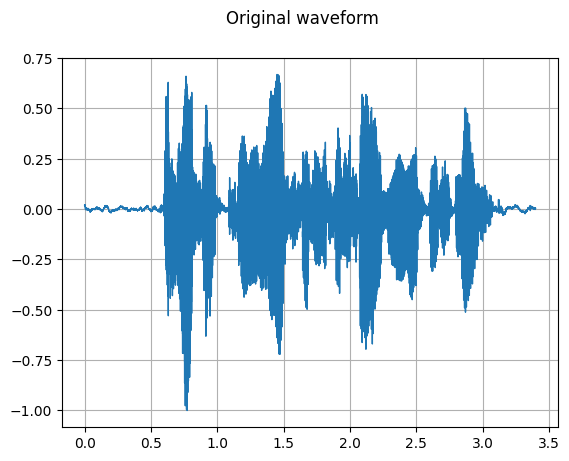

In [35]:
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform")
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

In [27]:
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

In [29]:
# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

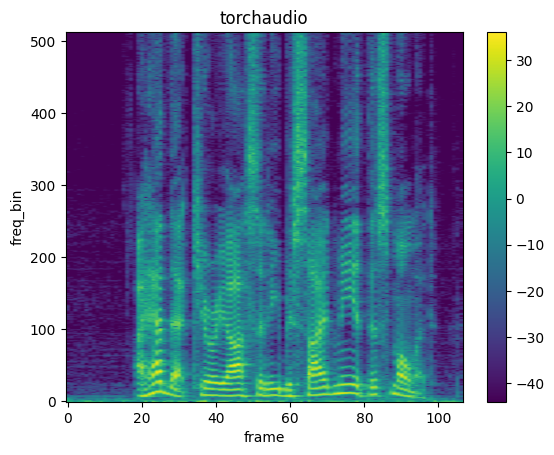

In [30]:
plot_spectrogram(spec[0], title="torchaudio")

torch.audio는 같은 sample에서 정보량이 훨씬 많은것을 볼 수 있다.
그 이유는 librosa에선 melspectrogram을 뽑았고 여기는 spectrogram을 뽑았기 때문이다.

GriffinLim
----------

To recover a waveform from a spectrogram, you can use ``GriffinLim``.




In [31]:
torch.random.manual_seed(0)

n_fft = 1024
win_length = None
hop_length = 512

spec = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)(SPEECH_WAVEFORM)

In [32]:
griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)

In [33]:
reconstructed_waveform = griffin_lim(spec)

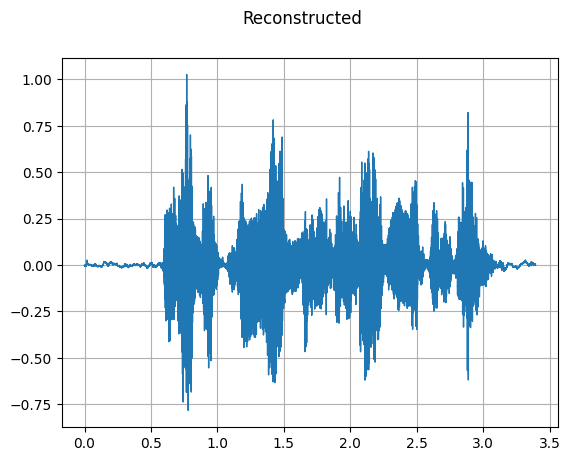

In [34]:
plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed")
Audio(reconstructed_waveform, rate=SAMPLE_RATE)

Mel Filter Bank
---------------

:py:func:`torchaudio.functional.melscale_fbanks` generates the filter bank
for converting frequency bins to mel-scale bins.

Since this function does not require input audio/features, there is no
equivalent transform in :py:func:`torchaudio.transforms`.




In [54]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)

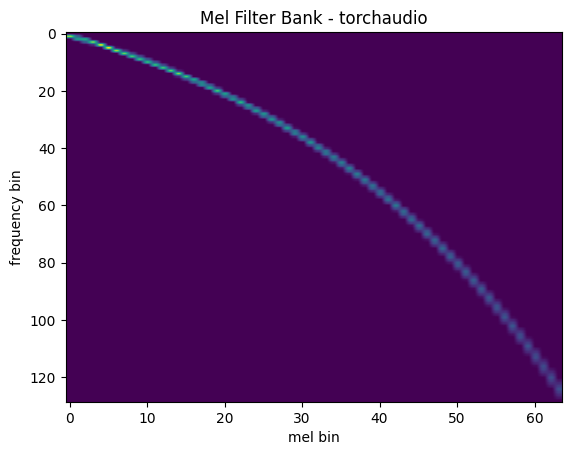

In [55]:
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

Comparison against librosa
~~~~~~~~~~~~~~~~~~~~~~~~~~

For reference, here is the equivalent way to get the mel filter bank
with ``librosa``.




In [56]:
mel_filters_librosa = librosa.filters.mel(
    sr=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=0.0,
    fmax=sample_rate / 2.0,
    norm="slaney",
    htk=True,
).T

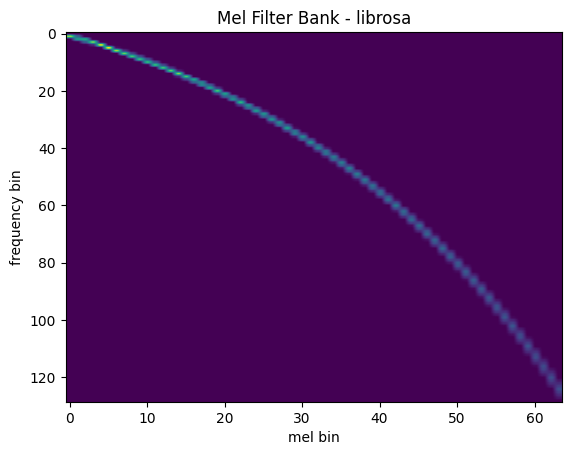

Mean Square Difference:  3.795462323290159e-17


In [57]:
plot_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print("Mean Square Difference: ", mse)

MelSpectrogram
--------------

Generating a mel-scale spectrogram involves generating a spectrogram
and performing mel-scale conversion. In ``torchaudio``,
:py:func:`torchaudio.transforms.MelSpectrogram` provides
this functionality.




In [66]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

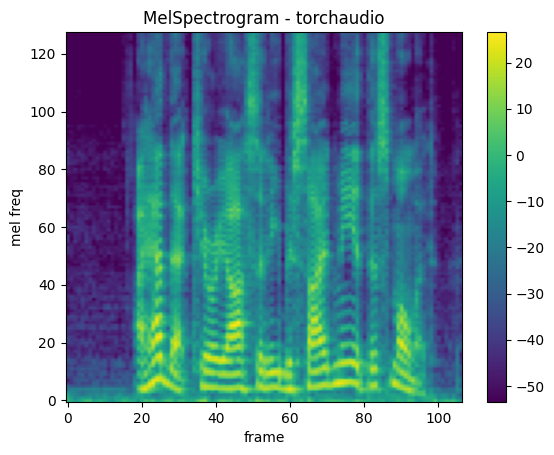

In [67]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

Comparison against librosa
~~~~~~~~~~~~~~~~~~~~~~~~~~

For reference, here is the equivalent means of generating mel-scale
spectrograms with ``librosa``.




In [ ]:
libro

In [123]:
melspec_librosa = librosa.feature.melspectrogram(
    y=aa,
    sr=22050,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

In [124]:
melspec_librosa.shape

(256, 388)

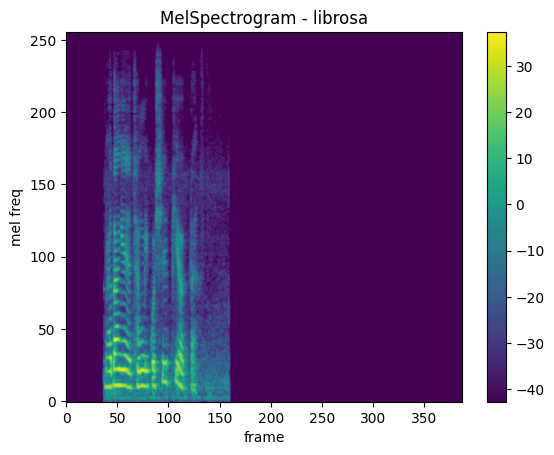

ValueError: operands could not be broadcast together with shapes (256,107) (256,388) 

In [127]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

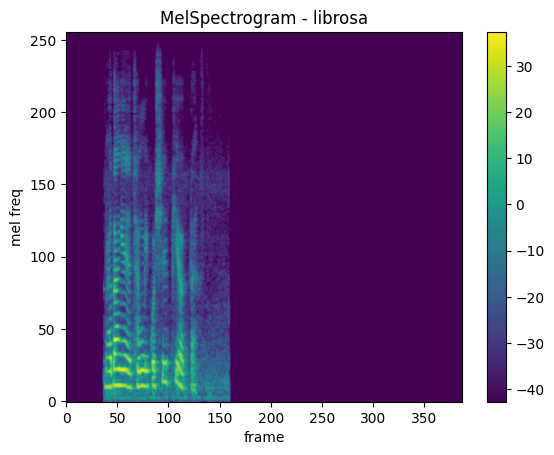

ValueError: operands could not be broadcast together with shapes (256,107) (256,388) 

In [110]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

MFCC
----




In [70]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)

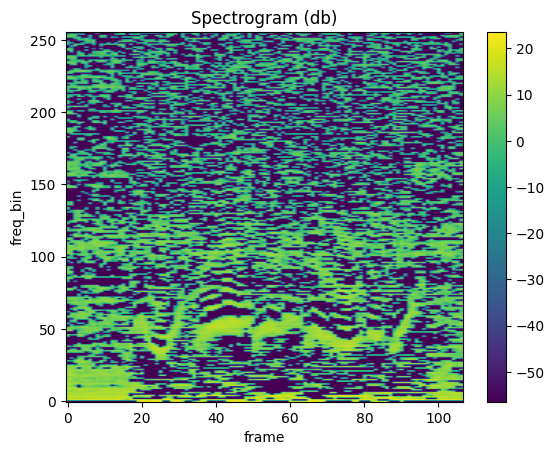

In [71]:
plot_spectrogram(mfcc[0])

Comparison against librosa
~~~~~~~~~~~~~~~~~~~~~~~~~~




In [129]:
melspec = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

mfcc_librosa = librosa.feature.mfcc(
    S=librosa.core.spectrum.power_to_db(melspec),
    n_mfcc=n_mfcc,
    dct_type=2,
    norm="ortho",
)

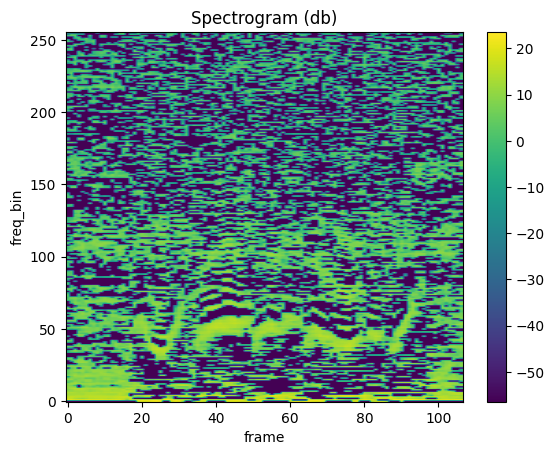

Mean Square Difference:  0.8103947639465332


In [73]:
plot_spectrogram(mfcc_librosa)

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print("Mean Square Difference: ", mse)

LFCC
----




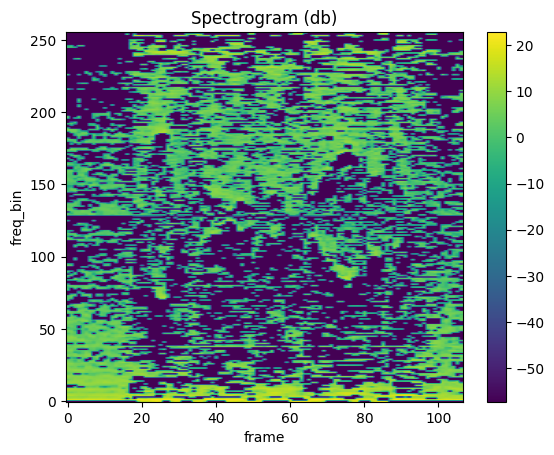

In [74]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(SPEECH_WAVEFORM)
plot_spectrogram(lfcc[0])

Pitch
-----




In [75]:
pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM, SAMPLE_RATE)

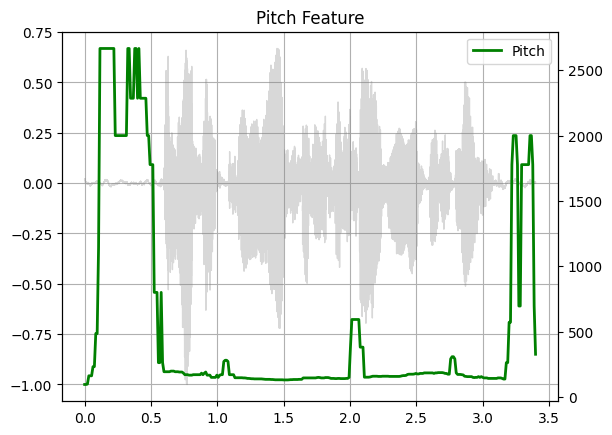

In [76]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)
    plt.show(block=False)


plot_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch)

Kaldi Pitch (beta)
------------------

Kaldi Pitch feature [1] is a pitch detection mechanism tuned for automatic
speech recognition (ASR) applications. This is a beta feature in ``torchaudio``,
and it is available as :py:func:`torchaudio.functional.compute_kaldi_pitch`.

1. A pitch extraction algorithm tuned for automatic speech recognition

   Ghahremani, B. BabaAli, D. Povey, K. Riedhammer, J. Trmal and S.
   Khudanpur

   2014 IEEE International Conference on Acoustics, Speech and Signal
   Processing (ICASSP), Florence, 2014, pp. 2494-2498, doi:
   10.1109/ICASSP.2014.6854049.
   [`abstract <https://ieeexplore.ieee.org/document/6854049>`__],
   [`paper <https://danielpovey.com/files/2014_icassp_pitch.pdf>`__]




In [77]:
pitch_feature = F.compute_kaldi_pitch(SPEECH_WAVEFORM, SAMPLE_RATE)
pitch, nfcc = pitch_feature[..., 0], pitch_feature[..., 1]

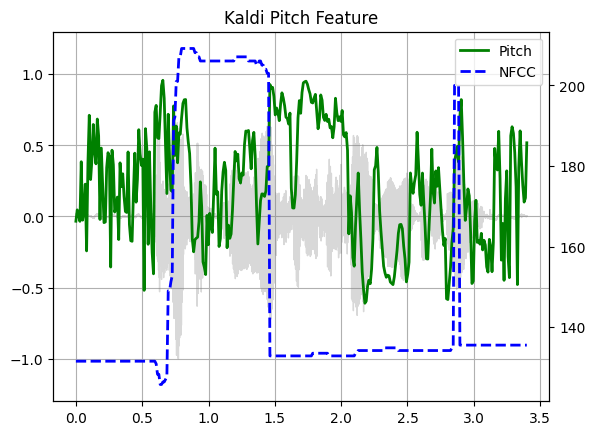

In [78]:
def plot_kaldi_pitch(waveform, sr, pitch, nfcc):
    _, axis = plt.subplots(1, 1)
    axis.set_title("Kaldi Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")
    axis.set_ylim((-1.3, 1.3))

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, nfcc.shape[1])
    ln2 = axis2.plot(time_axis, nfcc[0], linewidth=2, label="NFCC", color="blue", linestyle="--")

    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    axis.legend(lns, labels, loc=0)
    plt.show(block=False)


plot_kaldi_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch, nfcc)